In [13]:
import csv
import os
import numpy
import matplotlib.pyplot as plt
import statistics
from scipy.stats import pearsonr, ttest_ind, norm, median_absolute_deviation, ttest_ind
from statsmodels import robust
import math
import pandas as pd
import json

plt.rcParams.update({'font.size': 18})

In [3]:
def get_weighted_median(msd, msd_std, num_trials = 10000):
    msd = numpy.array(msd)
    msd_std = numpy.array(msd_std)
    
    #print(type(msd[0]))
    #print(type(msd_std[0]))
    weights = 1/msd_std**2
    norm_weights = weights/numpy.sum(weights)
    
    rvs = numpy.random.choice(msd, size = num_trials, p = norm_weights)
    weighted_median = statistics.median(rvs)
    weighted_mad = statistics.median(abs(rvs-weighted_median))

    return weighted_median, weighted_mad

In [4]:
def draw_random_sets(num_draws, n, msd_genes, msd_std_genes):
    # This function draws random sets of msd values without replacement
    choice = numpy.random.choice
    
    msd_all = numpy.empty((num_draws, n))
    msd_all.fill('nan')
    msd_std_all = numpy.empty((num_draws, n))
    msd_std_all.fill('nan')
        
    # Draw num_draws sets of draws
    for j in range(num_draws):
        # Select n MSD values at random from all KO MSD values (or WT values) (where n = number of genes with that kegg term)
            inds = choice(range(len(msd_genes)), size=n, replace=True)
            msd_all[j,:] = msd_genes[inds]
            msd_std_all[j,:] = msd_std_genes[inds]

    return msd_all, msd_std_all

def draw_random_sets_gaussian(num_draws, n, mean, std):
    # This function draws random sets of msd values without replacement
    
    msd_all = numpy.empty((num_draws, n))
    msd_all.fill('nan')
        
    # Draw num_draws sets of draws
    # Select n MSD values at random from all KO MSD values (or WT values) (where n = number of genes with that kegg term)
    msd_all = numpy.random.normal(loc = mean, scale = std, size = (num_draws,n))
    msd_std_all = numpy.ones(msd_all.shape)*0.01
    # Write code for mean var relationship of msd and msd ste
    
    return msd_all, msd_std_all


def calc_wmean(values, errors, axis = 1):
    wmean = numpy.average(values, weights = 1/(errors**2), axis = axis)
    wmean_ste = numpy.sqrt(1/(numpy.sum(1/(errors)**2, axis = axis)))
    return wmean, wmean_ste
def calc_mean(values, errors, axis = 1):
    mean = numpy.average(values, axis = axis)
    std = numpy.std(values, axis = axis)   # Change this one to ste, or above to std?
    return mean, std
def calc_median(values, errors, axis = 1):
    median = numpy.median(values, axis = axis)
    mad = median_absolute_deviation(values, axis = axis)
    return median, mad
def calc_wmedian(values, errors, axis = 1):
    if axis == 1:
        wmedian = numpy.empty(values.shape[0])
        wmedian.fill('nan')

        wmad = numpy.empty(values.shape[0])
        wmad.fill('nan')
        for i in range(values.shape[0]):
            wmedian[i], wmad[i] = get_weighted_median(values[i,:], errors[i,:], num_trials = 10000)
    elif axis == 0:
        wmedian, wmad = get_weighted_median(values, errors, num_trials = 100)
    return wmedian, wmad

def run_kegg(iteration_number, kegg_term, kegg_wmean, kegg_wmean_ste, fixed, all_average, calc_average, average_type, mean, std):
    # This function calculates the significance level for a given kegg term
    # by randomly drawing sets of MSD values (from KO or WT distribution), calculating median,
    # and calculating fraction of times that this is more extreme than the actual median msd for that kegg term
    
    # Inputs:
    # Set of actual MSD values for this kegg term and whether they are fixed or not
    # Set of MSDs to draw random values from

    actual_average, actual_error = calc_average(kegg_wmean, kegg_wmean_ste, axis = 0)
    
    n = len(kegg_wmean)
    n_fixed = numpy.count_nonzero(fixed)
    # Calculate the number of msd values that will be drawn randomly after subtracting the number of fixed msd values
    n_rand = n-n_fixed

    # Randomly draw num_draws sets of n msd (and error) values from msd_genes (msd_std_genes). 
    rand_wmean_all, rand_wmean_ste_all = draw_random_sets_gaussian(num_draws, n_rand, mean, std)
#     rand_wmean_all, rand_wmean_ste_all = draw_random_sets(num_draws, n_rand, rand_wmean_set, rand_wmean_ste_set)

    if n_fixed > 0:    
        fixed_ind = numpy.where(fixed)[0]
#         print(fixed_ind)

        fixed_wmean = kegg_wmean[fixed_ind]
        fixed_wmean_ste = kegg_wmean_ste[fixed_ind]

        rand_wmean_all_w_fixed = numpy.concatenate((rand_wmean_all, numpy.tile(fixed_wmean, (rand_wmean_all.shape[0],1))), axis = 1)
        rand_wmean_ste_all_w_fixed = numpy.concatenate((rand_wmean_ste_all, numpy.tile(fixed_wmean_ste, (rand_wmean_ste_all.shape[0],1))), axis = 1)
#         print(rand_wmean_all_w_fixed)
    else: 
        rand_wmean_all_w_fixed = rand_wmean_all
        rand_wmean_ste_all_w_fixed = rand_wmean_ste_all
    
    rand_average, rand_error = calc_average(rand_wmean_all_w_fixed, rand_wmean_ste_all_w_fixed)

#     statistic, pvalue = ttest_ind(kegg_wmean, numpy.transpose(rand_wmean_all), axis = 0, equal_var = False)
    


    # If the average random MSD value is more extreme than average actual MSD value, record it as a success
    # (More extreme = random less than actual if actual is less than average of overall distribution, more than actual if vice versa)
    if actual_average < all_average:
        draws_more_extreme = rand_average<=actual_average
    else:
        draws_more_extreme = rand_average>=actual_average
    average_p_value = numpy.sum(draws_more_extreme)/num_draws
    # Return the fraction of draws that are more extreme   
    
#     print('mean msd for kegg term = ' + str(numpy.mean(kegg_wmean)))
    
    plt.ioff
#     average_pvalue = numpy.mean(pvalue)
    h, b = numpy.histogram(kegg_wmean, density = True)
    b = b[:-1]+(b[1]-b[0])/2
    plt.plot(b, h, 'o-', alpha = 0.5, label = 'true')
    
    h, b = numpy.histogram(kegg_wmean, weights = 1/(kegg_wmean_ste**2), density = True)
    b = b[:-1]+(b[1]-b[0])/2
    plt.plot(b, h, 'o-', alpha = 0.5, label = 'weighted true')
    
    h, b = numpy.histogram(numpy.transpose(rand_average), density = True)
    b = b[:-1]+(b[1]-b[0])/2
    plt.plot(b, h, 'o-', alpha = 0.5, label = 'wt avg')
    
    plt.scatter(actual_average, 0, 200, c = 'tab:orange', marker = 'x', label = 'true avg')
    plt.scatter(all_average, 0, 200, c = 'k', marker = '+', label = 'all wt avg')
    
    plt.xlabel('MSD')
    plt.ylabel('prob')
    plt.title(kegg_term + '\n n = ' + str(n) + ', p = ' + str(round(average_p_value, 6)))
    
    plt.legend(loc = 'upper left')
    
    plt.xlim([0.3, 1.3])
    
#     plt.tight_layout()
        
    plt.savefig('/Users/qinqinyu/Documents/hallatschek_lab/data_changed/20200228_spatial_genetic_drift_summary/kegg_analysis/' + average_type + '_wt/output_figures/iteration' + str(iteration_number) + '/' + kegg_term + str(iteration_number) + '.pdf')
    

    
    plt.close()
#     plt.show()

    return average_p_value

In [4]:
# Import data as dataframe and get some general information

filename = '/Users/qinqinyu/Documents/hallatschek_lab/data_changed/20200228_spatial_genetic_drift_summary/all_exp_rel_wmean_replicated_msd_50um_kegg.csv'
df = pd.read_csv(filename)
print(df.columns)

# Keep only DE1-4
df_de1234 = df[0:384]

# Non-wild type and non-nan
df = df_de1234[df_de1234['genotype'] != 'WT']

df.reset_index(drop = True, inplace = True)   # Resets the indices to count up from 0
df = df.dropna(subset = ['wmean'])

df.reset_index(drop = True, inplace = True)   # Resets the indices to count up from 0

# Wild type and non-nan
df_wt = df_de1234[df_de1234['genotype'] == 'WT']
df_wt = df_wt.dropna(subset = ['wmean'])
df_wt.reset_index(drop = True, inplace = True)   # Resets the indices to count up from 0

# Scramble MSD values
msd_before_scrambling = df['wmean'].values.astype('float')
msd_std_before_scrambling = df['wmean_ste'].values.astype('float')

ind_after_scrambling = numpy.random.choice(range(len(msd_before_scrambling)), size = len(msd_before_scrambling), replace = False)
msd_after_scrambling = msd_before_scrambling[ind_after_scrambling]
msd_std_after_scrambling = msd_std_before_scrambling[ind_after_scrambling]

df_scrambled = df.copy()
df_scrambled['wmean'] = msd_after_scrambling
df_scrambled['wmean_ste'] = msd_std_after_scrambling

# Get the median value of the whole non-wt distribution
all_msd = df['wmean'].values.astype('float')
all_msd_std = df['wmean_ste'].values.astype('float')
# all_median = statistics.median(all_msd)  #<- need to change this to mean? Or other forms of averaging?
# all_mad = robust.mad(all_msd, c = 1)

Index(['experiment', 'position', 'genotype', 'position in KQY plates', 'wmean',
       'wmean_ste', 'n', 'uniprot_id', 'protein_name', 'gene_names', 'length',
       'KEGG', 'gene_ID', 'type', 'gene_symbol', 'start', 'stop',
       'description'],
      dtype='object')


In [5]:
# Get dictionary of unique GO terms to GO ID's
# Format: {term name: go id}

kegg_data = df['KEGG']

unique_kegg = {}

# Loop through each term's GO data
for j in range(len(kegg_data)):
    kegg_dict = kegg_data[j]
    # Loop through all of the KEGG terms
    if type(kegg_dict) == str:
        kegg_dict = kegg_dict[1:-1]
        kegg_data_split = kegg_dict.split(', ')
        for i in range(len(kegg_data_split)):
            entry = kegg_data_split[i]
            ind = entry.find(':')
            kegg_id = entry[1:ind-1]
            kegg_term = entry[ind+3:-1]
        
        unique_kegg[kegg_term] = kegg_id

In [8]:
# Get df of kegg terms with all genotypes, wmean MSD, and wmean_ste MSD, and number of genes in each kegg term

df_kegg_columns = ['kegg', 'kegg_id', 'genotypes', 'wmeans', 'wmean_stes', 'n']
data = numpy.empty((len(unique_kegg), len(df_kegg_columns)))
data[:] = numpy.nan
df_kegg = pd.DataFrame(data, columns = df_kegg_columns).astype('object')
# all_hits = {}

unique_kegg_terms = list(unique_kegg.keys())
# Loop through all kegg terms
for i in range(len(unique_kegg_terms)):
    kegg = unique_kegg_terms[i]
    kegg_id = unique_kegg[kegg]
    
    gene_hits = {}
    # Loop through all genes to see if it matches with the kegg term
    genotypes = []
    wmeans = []
    wmean_stes = []
    n = []
    for gene_ind in range(len(df)):
        # Get the terms associated with current gene
        current_terms = df.loc[gene_ind, ['KEGG']].values[0]
        
        if type(current_terms) == str: 
            # Check if kegg term of interest is associated with this gene
            ind = current_terms.find(kegg_id)
            #print(ind)

            # If it is associated with this gene, then:
            if ind != -1:

                # Get the name of the genotype
                genotype = df.loc[gene_ind,['genotype']].values[0]
                wmean = float(df.loc[gene_ind, ['wmean']].values[0])
                wmean_ste = float(df.loc[gene_ind, ['wmean_ste']].values[0])

                genotypes.append(genotype)
                wmeans.append(wmean)
                wmean_stes.append(wmean_ste)
                #print(gene_hits)
    n = len(genotypes)
    
    df_kegg.iat[i, 0] = kegg
    df_kegg.iat[i, 1] = kegg_id
    df_kegg.iat[i, 2] = numpy.array(genotypes)
    df_kegg.iat[i, 3] = numpy.array(wmeans)
    df_kegg.iat[i, 4] = numpy.array(wmean_stes)
    df_kegg.iat[i, 5] = n
df_kegg

,kegg,kegg_id,genotypes,wmeans,wmean_stes,n
0,Carbon metabolism,ebr01200,"[sdhA, glk, gnd, ackA, glpX, yihU, gcvT, fbaB]","[0.963309897, 0.8738289309999999, 1.055191669,...","[0.10279719400000001, 0.16589748099999999, 0.1...",8
1,Metabolic pathways,ebr01100,"[sdhA, nuoJ, glk, gnd, nuoG, treA, ackA, dacA,...","[0.963309897, 1.018389103, 0.8738289309999999,...","[0.10279719400000001, 0.100770725, 0.165897480...",48
2,Two-component system,ebr02020,"[evgA, rstA, basR, cydB, ddpX, fdnG, baeR, flg...","[0.8094262879999999, 0.602760947, 0.77059387, ...","[0.096419227, 0.07883019200000001, 0.106624021...",9
3,Biosynthesis of secondary metabolites,ebr01110,"[sdhA, glk, gnd, treA, glpX, ilvH, trpB, argH,...","[0.963309897, 0.8738289309999999, 1.055191669,...","[0.10279719400000001, 0.16589748099999999, 0.1...",18
4,Homologous recombination,ebr03440,[recA],[0.23940528],[0.039862646],1
5,Microbial metabolism in diverse environments,ebr01120,"[sdhA, glk, gnd, ackA, glpX, ylbA, xdhB, aldA,...","[0.963309897, 0.8738289309999999, 1.055191669,...","[0.10279719400000001, 0.16589748099999999, 0.1...",15
6,ABC transporters,ebr02010,"[yejF, fhuC, cysA, nikC, dppB]","[1.3155453609999999, 1.238066136, 1.063219834,...","[0.203746605, 0.159964591, 0.201971239, 0.1375...",5
7,Bacterial secretion system,ebr03070,[yghD],[0.7583000059999999],[0.105727454],1
8,Base excision repair,ebr03410,[alkA],[0.6371668979999999],[0.10814703199999999],1
9,Biosynthesis of amino acids,ebr01230,"[ilvH, trpB, argH, metH, leuA, fbaB]","[1.009637223, 1.118610763, 1.036817053, 1.1217...","[0.14164681, 0.105765383, 0.14780937800000002,...",6


In [20]:
# Filter the kegg terms that have at least a threshold number of genes
thresh = 3
df_kegg_thresh = df_kegg[df_kegg['n']>=thresh]
df_kegg_thresh.reset_index(drop = True, inplace = True)

In [23]:
# Testing significance of kegg terms against scrambled MSDs
# Treat each kegg term as an independent hypothesis, and use greedy alkeggrithm (pick the most significant each time)

# Define parameters
pvalue_per_term = 0.05   # Threshold p value per term
num_draws = 10**4#10**5  # Number of draws of scrambled values
average_type = 'weighted_median_msd'  # Choose the type of averaging to use

print('average type = ' + average_type)

# Defining the corresponding error type name for each averaging type
if average_type == 'wmean_msd':
    error_type = 'wmean_ste_msd'
    calc_average = calc_wmean
elif average_type == 'mean_msd':
    error_type = 'std_msd'
    calc_average = calc_mean
elif average_type == 'median_msd':
    error_type = 'mad_msd'
    calc_average = calc_median
elif average_type == 'weighted_median_msd':
    error_type = 'weighted_mad_msd'
    calc_average = calc_wmedian
else:
    raise NameError('This average type is not one of the options!')

avg_all = numpy.empty(len(df_kegg_thresh))
avg_all.fill('nan')

error_all = numpy.empty(len(df_kegg_thresh))
error_all.fill('nan')

for m in range(len(df_kegg_thresh)):
    avg, error = calc_average(df_kegg_thresh['wmeans'][m], df_kegg_thresh['wmean_stes'][m], axis = 0)
    avg_all[m] = avg
    error_all[m] = error

df_kegg_thresh_new = df_kegg_thresh.copy()
df_kegg_thresh_new[average_type] = avg_all
df_kegg_thresh_new[error_type] = error_all
    
# Make a copy of the df of genes and msd values to change while iterating
df_iteration = df.copy()

# Make new column keeping track of if msd of that gene should be fixed
df_iteration['fixed'] = 0

# Initiate dataframe for saving the significant terms and pvalues
df_significant_terms = pd.DataFrame(columns = ['kegg', 'pvalue', average_type, error_type, 'iteration'])

# Also initiate dataframe for saving the pvalues for all terms in all iterations
df_iteration_significances = df_kegg_thresh_new.copy()

# Keep track of which terms need to be tested and which have already been deemed as significant
ind_terms_to_test = numpy.asarray(range(len(df_kegg_thresh_new)))

# Make a numpy array of all of the msd values that can be drawn from (WT)
msd_genes = df_wt['wmean'].values.astype('float')
msd_std_genes = df_wt['wmean_ste'].values.astype('float')

msd_genes = msd_genes[~numpy.isnan(msd_genes)]
msd_std_genes = msd_std_genes[~numpy.isnan(msd_std_genes)]

mean, std = norm.fit(msd_genes)

all_average, all_error = calc_average(msd_genes, msd_std_genes, axis = 0)

print('all genotypes msd = ' + str(all_average) + '\n')
print('wt msd = ' + str(round(mean,3)) + '+/-' + str(round(std,3)) + '\n')


# Iterate through all kegg terms
for iteration in range(len(df_kegg_thresh)):
#     print(ind_terms_to_test)
    iteration_folder = '/Users/qinqinyu/Documents/hallatschek_lab/data_changed/20200228_spatial_genetic_drift_summary/kegg_analysis/' + average_type + '_wt/output_figures/iteration' + str(iteration)
    if not os.path.exists(iteration_folder):
        os.mkdir(iteration_folder)
        
    # Calculate the number of terms to be tested
    num_tested_terms = len(ind_terms_to_test)
    
    # Calculate the multiple hypothesis testing corrected p value
    single_term_sig = pvalue_per_term/(2*(num_tested_terms - 1))
                  
    # Print the iteration, the number of kegg terms tested, and the multiple hypothesis testing corrected single term significance level
    print('iteration = ' + str(iteration) + ', # kegg terms tested = ' + str(len(ind_terms_to_test)) + ', mult hyp corr sig level = ' + str(round(single_term_sig, 5)))
    
    # Make a numpy array of all of the msd values that can be drawn from (all MSD values that are not fixed)
    
#     # Get the MSD value and error for terms that are not fixed (can still draw from)
#     rand_wmean_set = df_iteration[df_iteration['fixed'] == 0]['wmean'].values.astype('float')
#     rand_wmean_ste_set = df_iteration[df_iteration['fixed'] == 0]['wmean_ste'].values.astype('float')
    
    fixed_genotypes = df_iteration[df_iteration['fixed'] == 1]['genotype'].values
    print('fixed genotypes = ' + str(fixed_genotypes))

    frac_extreme = numpy.empty(len(ind_terms_to_test))
    frac_extreme.fill('nan')
    # Calculate the fraction of 'successes' (random draw more extreme than actual value)
    
    ind = 0
    for i in ind_terms_to_test:
    
        kegg = df_kegg_thresh_new.at[i, 'kegg']
        kegg_wmean = df_kegg_thresh_new.at[i,'wmeans']

        kegg_wmean_ste = df_kegg_thresh_new.at[i,'wmean_stes']
        genotypes = df_kegg_thresh_new.at[i,'genotypes']
        
        fixed = numpy.isin(genotypes, fixed_genotypes)
        
        print(str(i) + '. ' + str(kegg) + ', fixed genotypes = ' + str(genotypes[fixed]))
        
        average_p_value = run_kegg(iteration, kegg, kegg_wmean, kegg_wmean_ste, fixed, all_average, calc_average, average_type, mean, std)

        frac_extreme[ind] = average_p_value
        ind = ind+1
    
    # Save the p values for each term in this iteration
    df_iteration_significances.at[ind_terms_to_test, 'pvalue_iteration' + str(iteration)] = frac_extreme
    
    # Check if there are any significant kegg terms
    if len(numpy.nonzero(frac_extreme<single_term_sig)[0])==0:
        break
    else:
        # Find most significant term
        local_ind_sig = numpy.argmin(frac_extreme)
        
        print('all significant terms =' + str(numpy.nonzero(frac_extreme<single_term_sig)[0]))
        print('most significant term =' + str(local_ind_sig))
                 
        ind_sig = ind_terms_to_test[local_ind_sig]
        sig_term = df_kegg_thresh_new['kegg'][ind_sig]
        
        actual_average = df_kegg_thresh_new[df_kegg_thresh_new['kegg'] == sig_term][average_type].values[0]
        actual_error = df_kegg_thresh_new[df_kegg_thresh_new['kegg'] == sig_term][error_type].values[0]
        
        genotypes = df_kegg_thresh_new[df_kegg_thresh_new['kegg'] == sig_term]['genotypes'].values[0]

        print(genotypes)
        
        p_value = frac_extreme[local_ind_sig]

        # Save significant kegg term and associated values into a dataframe
        df2 = pd.DataFrame([[sig_term, p_value, actual_average, actual_error, iteration]], columns = ['kegg', 'pvalue', average_type, error_type, 'iteration'], index = [iteration])
        df_significant_terms = df_significant_terms.append(df2)  

        # Find genes that have this term and update the list of MSDs to randomly choose from
        for gene in genotypes:             
            df_iteration.at[[numpy.nonzero(df_iteration['genotype'] == gene)[0][0]], ['fixed']] = 1
            
        # Update the list of kegg terms to test
        ind_terms_to_test = numpy.delete(ind_terms_to_test, local_ind_sig)

    # Save dataframes into csv
    df_iteration_significances.to_csv('/Users/qinqinyu/Documents/hallatschek_lab/data_changed/20200228_spatial_genetic_drift_summary/kegg_analysis/' + average_type + '_wt/df_iteration_significances.csv')
    df_significant_terms.to_csv('/Users/qinqinyu/Documents/hallatschek_lab/data_changed/20200228_spatial_genetic_drift_summary/kegg_analysis/' + average_type + '_wt/df_significant_terms.csv')

average type = weighted_median_msd
all genotypes msd = 0.988368247

wt msd = 1.011+/-0.062

iteration = 0, # kegg terms tested = 8, mult hyp corr sig level = 0.00357
fixed genotypes = []
0. Carbon metabolism, fixed genotypes = []
1. Metabolic pathways, fixed genotypes = []
2. Two-component system, fixed genotypes = []
3. Biosynthesis of secondary metabolites, fixed genotypes = []
4. Microbial metabolism in diverse environments, fixed genotypes = []
5. ABC transporters, fixed genotypes = []
6. Biosynthesis of amino acids, fixed genotypes = []
7. Flagellar assembly, fixed genotypes = []
all significant terms =[0 1 2 4 5]
most significant term =0
['sdhA' 'glk' 'gnd' 'ackA' 'glpX' 'yihU' 'gcvT' 'fbaB']
iteration = 1, # kegg terms tested = 7, mult hyp corr sig level = 0.00417
fixed genotypes = ['sdhA' 'glk' 'gnd' 'ackA' 'glpX' 'yihU' 'gcvT' 'fbaB']
1. Metabolic pathways, fixed genotypes = ['sdhA' 'glk' 'gnd' 'ackA' 'glpX' 'yihU' 'gcvT' 'fbaB']


/Users/qinqinyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


2. Two-component system, fixed genotypes = []
3. Biosynthesis of secondary metabolites, fixed genotypes = ['sdhA' 'glk' 'gnd' 'glpX' 'gcvT' 'fbaB']
4. Microbial metabolism in diverse environments, fixed genotypes = ['sdhA' 'glk' 'gnd' 'ackA' 'glpX' 'fbaB']
5. ABC transporters, fixed genotypes = []
6. Biosynthesis of amino acids, fixed genotypes = ['fbaB']
7. Flagellar assembly, fixed genotypes = []
all significant terms =[0 1 2 3 4]
most significant term =0
['sdhA' 'nuoJ' 'glk' 'gnd' 'nuoG' 'treA' 'ackA' 'dacA' 'glpX' 'ylbA'
 'yqcD' 'ybgJ' 'gor' 'xdhB' 'yihU' 'ilvH' 'trpB' 'argH' 'speG' 'metH'
 'leuA' 'bioF' 'thiE' 'ubiE' 'lplA' 'nagZ' 'otsB' 'putA' 'phnP' 'gcvT'
 'aldA' 'hcaF' 'gatD' 'pyrB' 'tdcD' 'rspA' 'melA' 'ygfG' 'ulaA' 'fbaB'
 'phnM' 'yeaD' 'udp' 'ssuE' 'mhpD' 'ynbB' 'mobA' 'gadA']
iteration = 2, # kegg terms tested = 6, mult hyp corr sig level = 0.005
fixed genotypes = ['sdhA' 'nuoJ' 'glk' 'gnd' 'nuoG' 'treA' 'ackA' 'dacA' 'glpX' 'ylbA'
 'yqcD' 'ybgJ' 'gor' 'xdhB' 'yihU' 'ilvH'

/Users/qinqinyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


3. Biosynthesis of secondary metabolites, fixed genotypes = ['sdhA' 'glk' 'gnd' 'treA' 'glpX' 'ilvH' 'trpB' 'argH' 'metH' 'leuA'
 'ubiE' 'otsB' 'putA' 'gcvT' 'fbaB' 'yeaD' 'ynbB' 'gadA']
4. Microbial metabolism in diverse environments, fixed genotypes = ['sdhA' 'glk' 'gnd' 'ackA' 'glpX' 'ylbA' 'xdhB' 'aldA' 'hcaF' 'ulaA'
 'fbaB' 'yeaD' 'mhpD' 'gadA']
5. ABC transporters, fixed genotypes = []
6. Biosynthesis of amino acids, fixed genotypes = ['ilvH' 'trpB' 'argH' 'metH' 'leuA' 'fbaB']
7. Flagellar assembly, fixed genotypes = []
all significant terms =[0 1 2 3]
most significant term =0
['evgA' 'rstA' 'basR' 'cydB' 'ddpX' 'fdnG' 'baeR' 'flgM' 'fecI']
iteration = 3, # kegg terms tested = 5, mult hyp corr sig level = 0.00625
fixed genotypes = ['sdhA' 'nuoJ' 'glk' 'evgA' 'gnd' 'nuoG' 'rstA' 'basR' 'treA' 'ackA'
 'cydB' 'dacA' 'glpX' 'ylbA' 'ddpX' 'yqcD' 'ybgJ' 'gor' 'xdhB' 'yihU'
 'ilvH' 'trpB' 'argH' 'speG' 'metH' 'leuA' 'bioF' 'thiE' 'ubiE' 'lplA'
 'nagZ' 'otsB' 'putA' 'phnP' 'gcvT' 'aldA'

/Users/qinqinyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


4. Microbial metabolism in diverse environments, fixed genotypes = ['sdhA' 'glk' 'gnd' 'ackA' 'glpX' 'ylbA' 'xdhB' 'aldA' 'hcaF' 'ulaA'
 'fbaB' 'yeaD' 'mhpD' 'gadA']
5. ABC transporters, fixed genotypes = []
6. Biosynthesis of amino acids, fixed genotypes = ['ilvH' 'trpB' 'argH' 'metH' 'leuA' 'fbaB']
7. Flagellar assembly, fixed genotypes = ['flgM']
all significant terms =[1 2]
most significant term =1
['sdhA' 'glk' 'gnd' 'ackA' 'glpX' 'ylbA' 'xdhB' 'aldA' 'hcaF' 'nemA'
 'ulaA' 'fbaB' 'yeaD' 'mhpD' 'gadA']
iteration = 4, # kegg terms tested = 4, mult hyp corr sig level = 0.00833
fixed genotypes = ['sdhA' 'nuoJ' 'glk' 'evgA' 'gnd' 'nuoG' 'rstA' 'basR' 'treA' 'ackA'
 'cydB' 'dacA' 'glpX' 'ylbA' 'ddpX' 'yqcD' 'ybgJ' 'gor' 'xdhB' 'yihU'
 'ilvH' 'trpB' 'argH' 'speG' 'metH' 'leuA' 'bioF' 'thiE' 'ubiE' 'lplA'
 'nagZ' 'otsB' 'putA' 'phnP' 'gcvT' 'aldA' 'fdnG' 'hcaF' 'gatD' 'pyrB'
 'tdcD' 'rspA' 'nemA' 'melA' 'ygfG' 'ulaA' 'fbaB' 'phnM' 'yeaD' 'udp'
 'ssuE' 'mhpD' 'baeR' 'flgM' 'fecI' 'ynbB' 'm

/Users/qinqinyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


5. ABC transporters, fixed genotypes = []
6. Biosynthesis of amino acids, fixed genotypes = ['ilvH' 'trpB' 'argH' 'metH' 'leuA' 'fbaB']
7. Flagellar assembly, fixed genotypes = ['flgM']
all significant terms =[1]
most significant term =1
['yejF' 'fhuC' 'cysA' 'nikC' 'dppB']
iteration = 5, # kegg terms tested = 3, mult hyp corr sig level = 0.0125
fixed genotypes = ['sdhA' 'nuoJ' 'glk' 'evgA' 'gnd' 'nuoG' 'rstA' 'basR' 'treA' 'ackA'
 'cydB' 'dacA' 'glpX' 'ylbA' 'ddpX' 'yqcD' 'ybgJ' 'yejF' 'gor' 'xdhB'
 'yihU' 'fhuC' 'ilvH' 'trpB' 'argH' 'speG' 'metH' 'leuA' 'bioF' 'thiE'
 'ubiE' 'lplA' 'nagZ' 'otsB' 'putA' 'phnP' 'gcvT' 'aldA' 'fdnG' 'hcaF'
 'gatD' 'pyrB' 'cysA' 'nikC' 'dppB' 'tdcD' 'rspA' 'nemA' 'melA' 'ygfG'
 'ulaA' 'fbaB' 'phnM' 'yeaD' 'udp' 'ssuE' 'mhpD' 'baeR' 'flgM' 'fecI'
 'ynbB' 'mobA' 'gadA']
3. Biosynthesis of secondary metabolites, fixed genotypes = ['sdhA' 'glk' 'gnd' 'treA' 'glpX' 'ilvH' 'trpB' 'argH' 'metH' 'leuA'
 'ubiE' 'otsB' 'putA' 'gcvT' 'fbaB' 'yeaD' 'ynbB' 'gadA']


/Users/qinqinyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


6. Biosynthesis of amino acids, fixed genotypes = ['ilvH' 'trpB' 'argH' 'metH' 'leuA' 'fbaB']
7. Flagellar assembly, fixed genotypes = ['flgM']


In [5]:
df_iteration_significances = pd.read_csv('/Users/qinqinyu/Documents/hallatschek_lab/data_changed/20200228_spatial_genetic_drift_summary/kegg_analysis/weighted_median_msd_wt/df_iteration_significances.csv', index_col = 0)
print(df_iteration_significances.columns)

# Import data as dataframe and get some general information

filename = '/Users/qinqinyu/Documents/hallatschek_lab/data_changed/20200228_spatial_genetic_drift_summary/all_exp_rel_wmean_replicated_msd_50um_kegg.csv'
df = pd.read_csv(filename)
df_de1234 = df[0:384]
df_wt = df_de1234[df_de1234['genotype'] == 'WT']
df_wt = df_wt.dropna(subset = ['wmean'])
df_wt.reset_index(drop = True, inplace = True)   # Resets the indices to count up from 0

msd_genes = df_wt['wmean'].values.astype('float')
msd_std_genes = df_wt['wmean_ste'].values.astype('float')

msd_genes = msd_genes[~numpy.isnan(msd_genes)]
msd_std_genes = msd_std_genes[~numpy.isnan(msd_std_genes)]

mean, std = norm.fit(msd_genes)
all_average, all_error = calc_wmedian(msd_genes, msd_std_genes, axis = 0)

Index(['kegg', 'kegg_id', 'genotypes', 'wmeans', 'wmean_stes', 'n',
       'weighted_median_msd', 'weighted_mad_msd', 'pvalue_iteration0',
       'pvalue_iteration1', 'pvalue_iteration2', 'pvalue_iteration3',
       'pvalue_iteration4'],
      dtype='object')


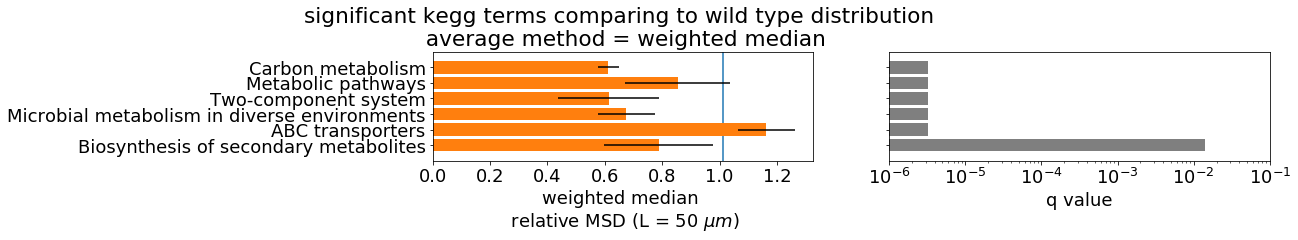

In [14]:
from matplotlib.cm import ScalarMappable
from statsmodels.stats.multitest import multipletests

df_sorted = df_iteration_significances.sort_values('pvalue_iteration0').reset_index(drop = True)

num_terms = len(df_sorted)

df_sorted['pvalue_iteration0'].replace({0:10**-6}, inplace = True) 

pvalues = df_sorted['pvalue_iteration0']
(reject, pvals_corrected, alphacSidak, alphacBonf) =  multipletests(pvalues, method = 'fdr_bh')

pvals_corrected = pvals_corrected * 2

alpha = 0.025

df_sorted_sig = df_sorted[pvals_corrected<alpha]

my_cmap = plt.cm.get_cmap('Greys')
data_color = numpy.log10(pvals_corrected[pvals_corrected<alpha])

data_color_rescaled = data_color - numpy.min(data_color)
data_color_rescaled2 = data_color_rescaled/numpy.max(data_color_rescaled)
colors = my_cmap(data_color_rescaled2)

fig, ax = plt.subplots(1, 2, figsize = (15,2))
b = ax[0].barh(df_sorted_sig.index, df_sorted_sig['weighted_median_msd'], xerr = df_sorted_sig['weighted_mad_msd'], align='center', zorder = 2, color = 'tab:orange')#, color = colors, edgecolor = 'black', alpha = 0.5, zorder = 2)
ax[0].plot([all_average, all_average], [-1, len(df_sorted_sig)], color = 'tab:blue', zorder = 1)
ax[0].set_xlabel('weighted median \n relative MSD (L = 50 $\mu m$)')
ax[0].set_yticks(ticks = df_sorted_sig.index)
ax[0].set_title('significant kegg terms comparing to wild type distribution \n average method = weighted median')
ax[0].set_yticklabels( labels = df_sorted_sig['kegg'])
ax[0].set_ylim([-1, len(df_sorted_sig)])
ax[0].invert_yaxis()

# sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(min(data_color_rescaled2),max(data_color_rescaled2)))
# sm.set_array([])

# cbar = plt.colorbar(sm)

# alpha_ticks = numpy.log10(numpy.logspace(-6, -2, 5))
# alpha_ticks_rescaled = alpha_ticks-numpy.min(data_color)
# alpha_ticks_rescaled2 = alpha_ticks_rescaled/numpy.max(data_color_rescaled)
# cbar.set_ticks(alpha_ticks_rescaled2)
# print(alpha_ticks_rescaled2)
# print(alpha_ticks)
# # cbar.set_ticklabels([0.4, 0.2, 0.1])
# cbar.set_ticklabels(alpha_ticks)
# cbar.set_label('log(p value)')

# print(df_sorted.index)
# print(df_sorted['pvalue_iteration0']*num_terms)
ax[1].barh(df_sorted_sig.index, pvals_corrected[pvals_corrected<alpha], color = 'k', alpha = 0.5)
ax[1].set_xscale('log')
ax[1].set_xlabel('q value')
ax[1].set_yticks(ticks = df_sorted_sig.index)
ax[1].set_yticklabels(labels = [])
ax[1].set_xlim([10**-6, 10**-1])
ax[1].set_ylim([-1, len(df_sorted_sig)])
ax[1].invert_yaxis()

plt.savefig('/Users/qinqinyu/Documents/hallatschek_lab/data_changed/20200228_spatial_genetic_drift_summary/figures/significant_kegg_terms_wmedian_wt_v2.pdf')

In [ ]:
df_

In [45]:
df_sorted

,go,go_id,genotypes,wmeans,wmean_stes,n,weighted_median_msd,weighted_mad_msd,pvalue_iteration0
31,membrane,GO:0016020,['ackA' 'cydB' 'yfgC' 'gor' 'mdtF' 'slt' 'fdnG...,[0.57693633 0.41909958 0.18769914 0.926957 1...,[0.05814398 0.06379019 0.05113454 0.15723957 0...,11,0.576936,0.123685,0.000000
27,DNA-binding transcription activator activity,GO:0001216,['rstA' 'basR' 'baeR'],[0.60276095 0.77059387 0.91232223],[0.07883019 0.10662402 0.11199247],3,0.770594,0.141728,0.000000
28,phosphorelay response regulator activity,GO:0000156,['rstA' 'basR' 'baeR'],[0.60276095 0.77059387 0.91232223],[0.07883019 0.10662402 0.11199247],3,0.770594,0.141728,0.000000
29,response to antibiotic,GO:0046677,['basR' 'ydaC' 'ycbB' 'yadC' 'macA' 'mdtF' 'rf...,[0.77059387 1.0410508 1.11024954 1.3323952 0...,[0.10662402 0.15643481 0.14168851 0.34716378 0...,8,0.605214,0.075639,0.000000
30,outer membrane-bounded periplasmic space,GO:0030288,['treA' 'dacA' 'ybaE' 'yfgC' 'slt' 'fdnG'],[1.00003893 0.31908417 0.55699102 0.18769914 1...,[0.12370713 0.05180713 0.08114433 0.05113454 0...,6,0.319084,0.131385,0.000000
32,magnesium ion binding,GO:0000287,['ackA' 'ydaO' 'topB' 'speG' 'thiE' 'otsB' 'yf...,[0.57693633 0.90466688 1.17625973 1.13362205 0...,[0.05814398 0.12469642 0.17836962 0.15211999 0...,8,0.854324,0.169441,0.000000
35,endopeptidase activity,GO:0004175,['dacA' 'ydhO' 'yebA'],[0.31908417 0.83490452 0.79572951],[0.05180713 0.14124693 0.09433711],3,0.319084,0.000000,0.000000
36,cell wall organization,GO:0071555,['dacA' 'ddpX' 'ycbB' 'slt' 'nagZ' 'ydhO' 'yebA'],[0.31908417 0.61337474 1.11024954 1.10298413 0...,[0.05180713 0.07146592 0.14168851 0.13785658 0...,7,0.613375,0.294291,0.000000
37,peptidoglycan biosynthetic process,GO:0009252,['dacA' 'ycbB' 'nagZ'],[0.31908417 1.11024954 0.93970542],[0.05180713 0.14168851 0.16476494],3,0.319084,0.000000,0.000000
38,peptidoglycan metabolic process,GO:0000270,['dacA' 'ydhO' 'yebA'],[0.31908417 0.83490452 0.79572951],[0.05180713 0.14124693 0.09433711],3,0.319084,0.000000,0.000000


In [54]:
# Calculating the colony sizes of ABC transporters
gois = df_kegg[df_kegg['kegg'] == 'ABC transporters']['genotypes'].values[0]
numpy.mean(df_kegg[df_kegg['kegg'] == 'ABC transporters']['wmeans'].values[0])

1.1584689548

In [29]:
df_phenotypes = pd.read_csv('/Users/qinqinyu/Documents/hallatschek_lab/data_changed/20200228_spatial_genetic_drift_summary/all_exp_rel_wmean_replicated_msd_50um_area_roughness_gld_thickness_huang_cell_shape_volume_sa.csv')

In [73]:
df_gois = df_phenotypes[df_phenotypes['genotype'].isin(goi)]
df_gois.columns

Index(['experiment', 'position', 'genotype', 'position in KQY plates', 'wmean',
       'wmean_ste', 'n', 'area', 'area_ste', 'roughness', 'roughness_ste',
       'growth_layer_depth', 'growth_layer_depth_ste', 'thickness',
       'thickness_ste', 'phenotype_n', 'major', 'minor', 'ar', 'std_major',
       'std_minor', 'volume', 'sa'],
      dtype='object')

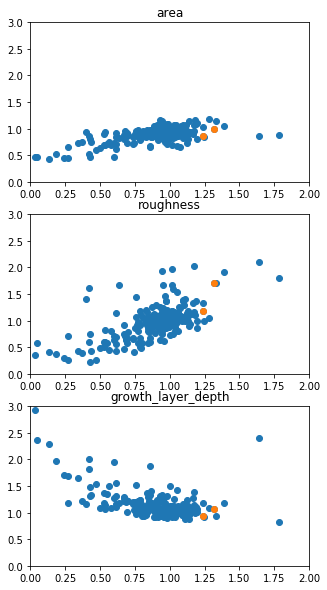

In [78]:
fig, ax = plt.subplots(3,1,figsize = (5,10))

phenotypes = ['area', 'roughness', 'growth_layer_depth']
for i in range(len(phenotypes)):
    ax[i].scatter(df_phenotypes['wmean'], df_phenotypes[phenotypes[i]])
    ax[i].scatter(df_gois['wmean'], df_gois[phenotypes[i]])
    ax[i].set_xlim([0,2])
    ax[i].set_ylim([0,3])
    ax[i].set_title(phenotypes[i])